## Imports

In [1]:
import numpy as np
from sklearn import datasets
import JOPLEn.singletask as jp
from JOPLEn.enums import *
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
from ax import optimize
import lightgbm as lgbm
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("cache") / "experiments"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"


## Parameters

In [2]:
lgbm_params = [
    {
        "name": "num_leaves",
        "type": "range",
        "bounds": [2, 32],
        "value_type": "int",
    },
    {
        "name": "n_estimators",
        "type": "range",
        "bounds": [10, 1000],
        "value_type": "int",
        "log_scale": True,
    },
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [1e-5, 1e-1],
        "value_type": "float",
    },
    {
        "name": "min_split_gain",
        "type": "range",
        "bounds": [0.0, 1.0],
        "value_type": "float",
    },
    {
        "name": "reg_alpha",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "reg_lambda",
        "type": "range",
        "bounds": [1e-5, 1e1],
        "value_type": "float",
        "log_scale": True,
    },
    {
        "name": "random_state",
        "type": "fixed",
        "value": 0,
        "value_type": "int",
    },
    {
        "name": "verbose",
        "type": "fixed",
        "value": -1,
        "value_type": "int",
    },
]


## Training Functions

In [12]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(params, x_train, y_train, x_val, y_val, x_test=None, y_test=None):
    model = lgbm.LGBMRegressor(**params)
    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[],
    )

    val_error = float(rmse(y_val.flatten(), model.predict(x_val)))

    if x_test is not None and y_test is not None:
        test_error = float(rmse(y_test.flatten(), model.predict(x_test)))
        return val_error, test_error, model
    else:
        return val_error, model


In [13]:
def dummy_regressor(x_train, x_val, x_test, y_train, y_val, y_test, indent=False):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = {
        "model_name": dummy.__class__.__name__,
        "rmse": float(rmse(y_test, y_pred)),
    }

    return res


## Run Experiments

In [14]:
def optimize_model(
    model_class, ds_path, n_trials, minimize, loss_type, overwrite=False
):
    ds_name = ds_path.name

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_info = dummy_regressor(
        x_train, x_val, x_test, y_train, y_val, y_test, indent=True
    )

    match model_class:
        case lgbm.LGBMRegressor:
            params = lgbm_params
            train_fn = train_lgbm
        case _:
            raise ValueError("Model not yet supported.")

    exp_name = model_class.__name__ + "_" + ds_name
    exp_path = Path("ax_runs") / f"{exp_name}.json"

    if not exp_path.exists() or overwrite:
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=exp_name,
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            round_params, trial_index = ax_client.get_next_trial()
            try:
                val_error, _ = train_fn(
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, _), _, _, train_time = train_fn(
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    return {
        "model_name": model_class.__name__,
        "val_score": val_error,
        "test_score": test_error,
        "train_time": train_time,
        "params": best_parameters,
        "dummy_loss": dummy_info["rmse"],
    }


In [15]:
reg_datasets = list((DS_PATH / "reg").iterdir())

reg_res = {}

itr = tqdm(reg_datasets)

for ds_path in itr:
    itr.set_description(f"Running LGBM on {ds_path.name: <30}")
    ds_res = optimize_model(
        lgbm.LGBMRegressor,
        ds_path,
        10,
        True,
        "rmse",
    )

    reg_res[ds_path.name] = ds_res


Running LGBM on titanic                       : 100%|██████████| 122/122 [00:43<00:00,  2.78it/s] 


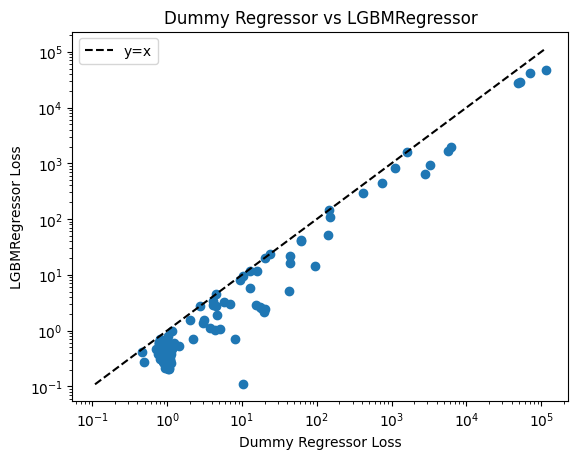

In [16]:
dummy_pred = [v["dummy_loss"] for v in reg_res.values()]
lgbm_loss = [v["test_score"] for v in reg_res.values()]

min_val = min(min(dummy_pred), min(lgbm_loss))
max_val = max(max(dummy_pred), max(lgbm_loss))

plt.plot([min_val, max_val], [min_val, max_val], color="k", linestyle="--", label="y=x")
plt.legend()

plt.scatter(dummy_pred, lgbm_loss)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Dummy Regressor Loss")
plt.ylabel("LGBMRegressor Loss")
plt.title("Dummy Regressor vs LGBMRegressor")

plt.show()
